# Experiments demo: GPGO vs. baseline

This notebook presents how to use our implementation of the GPGO algorithm to minimize functions when the number of evaluations is limited.
Evaluations are shown for:
* noiseless optimization, periodic and non-periodic
* noisy optimization

In [ ]:
!pip install pandas

In [36]:
import numpy as np
import sys
import time
import datetime
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2
logging.basicConfig(level=logging.INFO)
from collections import namedtuple
from IPython.core.display import Image, display

# import one_step_lookahead, scipy.optimizers and GAP measure (measure of improvement for optimization problems)
from gpgo import one_step_lookahead, scop, GAP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload




# Test functions

## Ackley-N (AN)
https://www.sfu.ca/~ssurjano/ackley.html

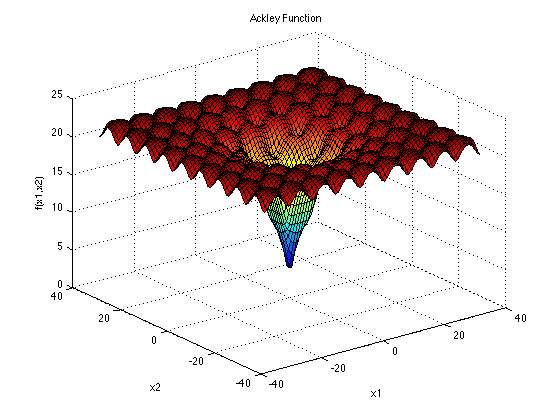

In [9]:
display(Image('https://www.sfu.ca/~ssurjano/ackley.png', width=650, unconfined=True))

* test region $[-32.8, 32.8]^D$
* $y^{*}$ = 0 at $\mathbf{x}$=$\mathbf{0}$

In [16]:
def TF_AN(x, a = 20, b = 0.2, c = 2*np.pi, sigma=None):
    """
    x must be n x d
    returns n x 1
    """
    global CNT
    CNT = CNT+1
    
    x = np.array([x]) if len(x.shape) < 2 else x
    d = x.shape[1]
    y1 = -a * np.exp(-b * np.sqrt((1/d) * np.sum(x**2, axis = 1))) 
    y2 = -np.exp((1/d) * np.sum(np.cos(c * x), axis = 1)) + a + np.exp(1)
    y = y1+y2
    if sigma: y = y + np.random.normal(loc=0.0, scale=sigma)
    return y

## Rastrigin-N (RN)
https://www.sfu.ca/~ssurjano/rastr.html

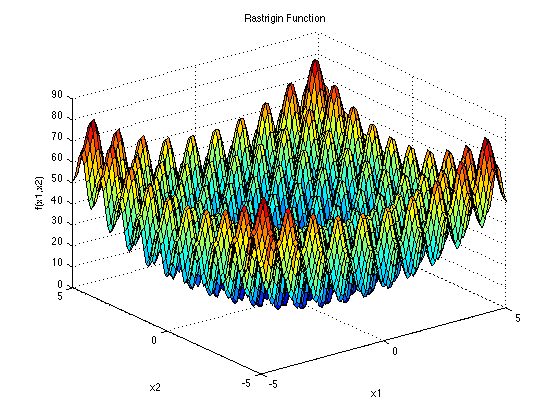

In [11]:
display(Image('https://www.sfu.ca/~ssurjano/rastr.png', width=750, unconfined=True))

* test region $[-5.12, 5.12]^2$ for all i
* $y^{*}$ = 0 at $x^{*}=(0,...,0)$

In [15]:
def TF_R2(x, sigma=None):
    """
    x must be n x d
    returns n x 1
    """
    global CNT
    CNT = CNT+1

    x = np.array([x]) if len(x.shape) < 2 else x
    assert len(x.shape)==2 and x.shape[1]==2
    x1, x2, d = x[:,0], x[:,1], x.shape[1]
    y = 10*d + x1**2-10*np.cos(2*np.pi*x1) + x2**2-10*np.cos(2*np.pi*x2)
    if sigma: y = y + np.random.normal(loc=0.0, scale=sigma)
    return y

## Goldstein-Price-2 (GP2)
https://www.sfu.ca/~ssurjano/goldpr.html

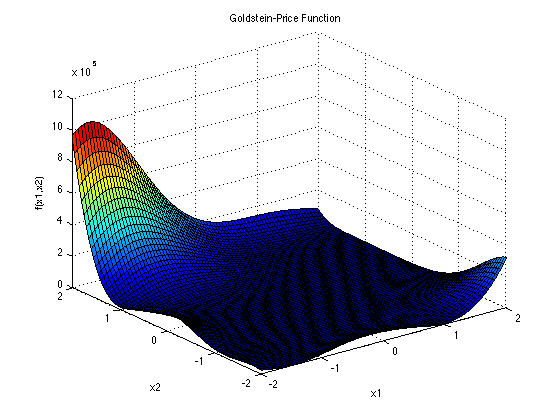

In [13]:
display(Image('https://www.sfu.ca/~ssurjano/goldpr.png', width=650, unconfined=True))

* test region $x_{i} \in [-2,2]$, for all i = 1,2
* $y^{*}$ = 3 at $\mathbf{x}=(0, -1)$

In [14]:
def TF_GP(x, sigma=None):
    """
    x must be n x d
    returns n x 1
    """
    global CNT
    CNT = CNT+1

    x = np.array([x]) if len(x.shape) < 2 else x
    assert len(x.shape)==2 and x.shape[1]==2
    x1, x2 = x[:,0], x[:,1]
    
    y1 = (1+(x1+x2+1)**2 * (19-14*x1+3*x1**2-14*x2+6*x1*x2+3*x2**2))
    y2 = (30 + (2*x1-3*x2)**2*(18-32*x1+12*x1**2+48*x2-36*x1*x2+27*x2**2))
    y = y1*y2
    if sigma: y = y + np.random.normal(loc=0.0, scale=sigma)
    return y

## Six-Hump Camel (C6-2)
https://www.sfu.ca/~ssurjano/camel6.html

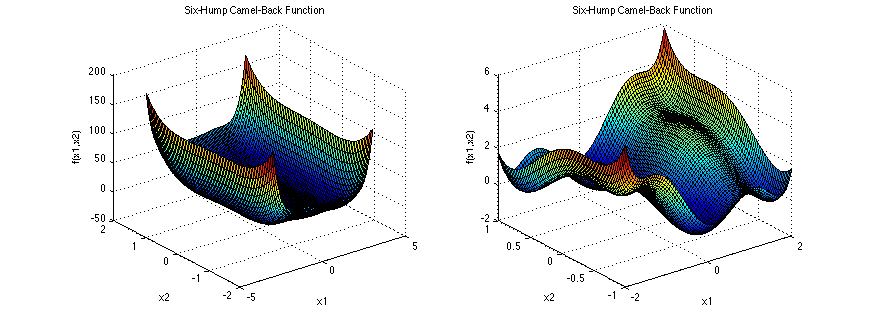

In [9]:
display(Image('https://www.sfu.ca/~ssurjano/camel6.png', width=720, unconfined=True))

* test region: $x_{1} \in [-3, 3]$, $x_{2} \in [-2, 2]$
* $y^{*}$ = -1.0316

In [20]:
def TF_C6(x, sigma=None):
    """
    x must be n x d
    returns n x 1
    """
    global CNT
    CNT = CNT+1

    x = np.array([x]) if len(x.shape) < 2 else x
    assert len(x.shape)==2 and x.shape[1]==2
    x1, x2 = x[:,0], x[:,1]
    y = (4 - 2.1*x1**2+((x1**4)/3))*x1**2 + x1*x2 + (-4+4*x2**2)*x2**2
    if sigma: y = y + np.random.normal(loc=0.0, scale=sigma)
    return y

# Experiments

* `d`: dimension 
* `test region`: for each test function, set expLoss to inf out of this
* `max_steps`: $10 d$/$20d$, noiseless/noisy
* `x_init`: medial point of test region (+noise)
* `num_trials`: 10

## Helpers

### Define baseline: Basin-Hoppin algorithm

In [21]:
from functools import partial

def sample_test_box(box):
    mins, maxs = box[0], box[1] 
    return np.array([np.random.uniform(low=mins[i], high=maxs[i]) for i in range(len(mins))])

class BoundingBox(object):
    def __init__(self, xmin, xmax):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin

def baseline_stopping_crit(x, f, accepted, max_eval=20):
    if CNT>=max_eval:
        return True
      
def run_baseline(test_fn, test_box, x0, y_opt, max_iter=5, noise=None, disp=False, optimizer="BFGS"):
    """Find the global minimum of a function using the basin-hopping algorithm
    Basin-hopping is a two-phase method that combines a global stepping algorithm
    with local minimization at each step.
    The algorithm is iterative with each cycle composed of the following features

    1.random perturbation of the coordinates
    2.local minimization (default BFGS)
    3.accept or reject the new coordinates based on the minimized function value


    """
    mybounds = BoundingBox(test_box[0, :], test_box[1,: ])
    minimizer_kwargs = {"method": optimizer}
    
    global CNT
    CNT = 0
    ret = scop.basinhopping(test_fn, x0=x0, 
                            minimizer_kwargs=minimizer_kwargs, 
                            accept_test=mybounds, 
                            callback=partial(baseline_stopping_crit, max_eval=max_iter),
                            niter=500, disp=disp)
    
    x_i = ret.x.reshape(x0.shape)
    g = GAP(test_fn, y_opt, x0[0], x_i[0])
    return g

### Define trial: `max_iter` steps of one-step lookahead

In [22]:
def run_trial(test_fn, test_box, x0, y_opt, max_iter=5, noise=None, theta_sample_count=8, disp=False, 
              optimizer=scop.fmin_bfgs, periodic=False, **kwargs):
    
    
    for k in range(max_iter):
        
        if noise is not None:   
            theta_prior = np.array([1, 1, 1, 1, np.mean(np.mean(test_fn(x0))), noise])
        else:
            theta_prior = np.array([1, 1, 1, 1, np.mean(np.mean(test_fn(x0)))])
        i_trial = kwargs.get('i_trial', 0)
        print(f'\rtrial {i_trial+1} iter {str(k+1).zfill(2)}/{str(max_iter).zfill(2)}', end='', flush=True)
        
        x_next, _, _, _, x0, y0 = one_step_lookahead(x0, test_fn(x0), theta_prior, test_box, 
                                                    theta_sample_count=theta_sample_count, optimizer=optimizer, 
                                                    disp=disp)        

        if (np.isscalar(x_next)):
            x_next = np.array([x_next])
            
        x_next = x_next.reshape((1, -1))
        x0 = np.vstack((x0, x_next))
    y0 = test_fn(x0)    
    x_0, x_i = x0[0], x0[y0 == y0.min()][0]
    g = GAP(test_fn, y_opt, x_0, x_i)
    return g


### Define experiment loop: `num_trials` runs over test functions

In [23]:
def run_experiment(test_fns, num_trials=15, noise=None, max_iter_mult=10, 
                   disp=False, periodic=False, optimizer=scop.fmin_bfgs, theta_sample_count=8,
                   **kwargs):
    """
    Performs num_trials runs of GPGO vs. Baseline over test functions.
    
    Arguments:
        test_fns: list of test functions
        num_trials: number of trials per test function
        noise: noise level
        max_iter_mult: number of iterations is dimensions times this value
        disp: print step informations
        periodic: use periodic component in convariance function or not
        optimizer: optimizer used to minimize expected loss fn (from scipy.optimizers)
        theta_sample_count: no. of theta samples used for marginalization

    Returns: results in pandas DataFrame
    
    """
    np.warnings.filterwarnings('ignore') # HAZARDOUS GAME
    print(f"[setup: one-step, periodic={periodic}, noise={noise}]\n")
    results, r = [], {}
    for tf in test_fns:
        d = tf.box.shape[1]
        max_iter = max_iter_mult*d if noise is None else 2*max_iter_mult*d        
        print(f"optimizing {tf.name}")
        
        scores, scores_bl, i_trial = [], [], 0
        t0 = time.time()
        while i_trial != num_trials:
            x0 = np.array([sample_test_box(tf.box)])

            try:
                g = run_trial(tf.fn, tf.box, x0, tf.y_opt, max_iter=max_iter, disp=disp, 
                              optimizer=scop.fmin_cg, i_trial=i_trial, periodic=periodic, noise=noise,
                              theta_sample_count=theta_sample_count,**kwargs)
            except Exception as e:
                continue
            global CNT
            CNT = 0
            g_bl = run_baseline(tf.fn, tf.box, x0, tf.y_opt, max_iter=max_iter, disp=False,
                               optimizer="CG", noise=noise)
            if disp: print(f"baseline evaluation: ", CNT)
            scores.append(g)
            scores_bl.append(g_bl)
            i_trial+=1
        
        print(f"\ntime: {datetime.timedelta(seconds=time.time()-t0)}\n")
        results.append({"gpgo": {tf.name: scores}, 
                        "baseline": {tf.name: scores_bl}})        
    return results

## Noiseless

In [27]:
TestFn = namedtuple("TestFn", ["name", "fn", "box", "y_opt"])

test_fns = [
    TestFn(name="C6", fn=TF_C6, box=np.array([[-3, -2], [3, 2]]), y_opt=-1.0316),
    TestFn(name="G-P", fn=TF_GP, box=np.array([[-2], [2]]).repeat(2).reshape(2,2), y_opt=3.0),
    TestFn(name="A2", fn=TF_AN, box=np.array([[-32.768], [32.768]]).repeat(2).reshape(2,2), y_opt=0.0),
    TestFn(name="A5", fn=TF_AN, box=np.array([[-32.768], [32.768]]).repeat(5).reshape(2,5), y_opt=0.0),
    TestFn(name="R2", fn=TF_R2, box=np.array([[-5.12], [5.12]]).repeat(2).reshape(2,2), y_opt=0.0),
]

### One-step, non-periodic

In [45]:
results = run_experiment(test_fns, num_trials=5, noise=None, max_iter_mult=10, periodic=False)

results

[setup: one-step, periodic=False, noise=None]

optimizing C6
trial 5 iter 20/20
time: 0:00:12.130918

optimizing G-P
trial 5 iter 20/20
time: 0:00:04.979964

optimizing A2
trial 5 iter 20/20
time: 0:00:09.241291

optimizing A5
trial 5 iter 50/50
time: 0:00:13.473358

optimizing R2
trial 5 iter 20/20
time: 0:00:46.311602



[{'gpgo': {'C6': [0.994, 0.0604, 0.9948, 0.9891, 0.9846]},
  'baseline': {'C6': [0.9929, 1.0, 0.9865, 1.0, 1.0]}},
 {'gpgo': {'G-P': [0.9883, 0.8958, 0.9986, 0.0, 0.9617]},
  'baseline': {'G-P': [1.0, 1.0, 0.9989, 1.0, 0.9845]}},
 {'gpgo': {'A2': [0.207, 0.6618, 0.109, 0.1722, 0.5956]},
  'baseline': {'A2': [0.0587, 0.0901, 1.0, 0.0787, 0.0774]}},
 {'gpgo': {'A5': [0.2574, 0.1468, 0.1773, 0.2401, 0.2672]},
  'baseline': {'A5': [0.0539, 0.0872, 0.0752, 0.0391, 0.1033]}},
 {'gpgo': {'R2': [0.3989, 0.9602, 0.0, 0.7316, 0.4086]},
  'baseline': {'R2': [0.7756, 0.8793, 0.2606, 0.4883, 0.5492]}}]

### One-step, periodic

In [46]:
results = run_experiment(test_fns, num_trials=5, noise=None, max_iter_mult=10, periodic=True)

results

[setup: one-step, periodic=True, noise=None]

optimizing C6
trial 5 iter 20/20
time: 0:00:16.456694

optimizing G-P
trial 5 iter 20/20
time: 0:00:04.463783

optimizing A2
trial 5 iter 20/20
time: 0:00:13.329640

optimizing A5
trial 5 iter 50/50
time: 0:00:15.572651

optimizing R2
trial 5 iter 20/20
time: 0:00:20.203138



[{'gpgo': {'C6': [0.9881, 0.9955, 0.9648, 0.943, 0.9999]},
  'baseline': {'C6': [0.9926, 1.0, 0.9565, 0.9471, 1.0]}},
 {'gpgo': {'G-P': [0.92, 0.6555, 0.9631, 0.9086, 0.8597]},
  'baseline': {'G-P': [1.0, 1.0, 1.0, 0.9708, 0.9219]}},
 {'gpgo': {'A2': [0.3781, 0.1096, 0.3795, 0.1643, 0.4066]},
  'baseline': {'A2': [0.0624, 0.0819, 0.0909, 0.0718, 0.0875]}},
 {'gpgo': {'A5': [0.0463, 0.2162, 0.1089, 0.1113, 0.1359]},
  'baseline': {'A5': [0.087, 0.0769, 0.0966, 0.0793, 0.0696]}},
 {'gpgo': {'R2': [0.7635, 0.6824, 0.7081, 0.332, 0.3666]},
  'baseline': {'R2': [0.712, 0.8089, 0.1254, 0.6621, 0.0772]}}]

## Noisy

In [47]:
noise = 0.1

results = run_experiment(test_fns, num_trials=5, noise=noise, max_iter_mult=10, periodic=False)

results

[setup: one-step, periodic=False, noise=0.1]

optimizing C6
trial 5 iter 40/40
time: 0:00:22.955920

optimizing G-P
trial 5 iter 40/40
time: 0:00:09.253139

optimizing A2
trial 5 iter 40/40
time: 0:00:42.263654

optimizing A5
trial 5 iter 100/100
time: 0:00:56.664719

optimizing R2
trial 5 iter 40/40
time: 0:00:14.490724



[{'gpgo': {'C6': [0.9988, 0.8611, 0.9338, 0.9887, 0.8785]},
  'baseline': {'C6': [1.0, 0.0546, 1.0, 0.9794, 1.0]}},
 {'gpgo': {'G-P': [0.9967, 0.9959, 0.9996, 0.9957, 0.9999]},
  'baseline': {'G-P': [1.0, 1.0, 1.0, 1.0, 1.0]}},
 {'gpgo': {'A2': [0.46, 0.7138, 0.5377, 0.4437, 0.2242]},
  'baseline': {'A2': [0.0797, 0.0895, 0.0688, 0.1016, 0.1403]}},
 {'gpgo': {'A5': [0.2559, 0.3823, 0.189, 0.2069, 0.2708]},
  'baseline': {'A5': [0.0893, 0.0983, 0.0974, 0.0985, 0.0843]}},
 {'gpgo': {'R2': [0.9426, 0.3507, 0.9087, 0.8246, 0.875]},
  'baseline': {'R2': [0.3992, 0.2728, 0.3695, 0.685, 0.5157]}}]